## Setting up Datasets

In [1]:
import torch 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch.nn.functional as F
from common.utils import get_u, F_l, F_nl
import numpy as np 

torch.manual_seed(0)
device = "cuda"

# setup domain
L = 1
nx = 100
x = torch.linspace(-L, L, nx) # x in domain [-1, 1]
dx = x[1] - x[0]
n_train = 100
n_valid = 10 

# generate training data
p_train = 2*torch.rand(n_train*3) - 1 # coeffs from -1 to 1
p_train = p_train.reshape(n_train, 3) # need 3 coeffs for each polynomial of degree p=2
# generate valid data
p_valid = 2*torch.rand(n_valid*3) - 1 
#p_valid = 2*torch.rand(n_valid*3) + 1 # coeffs from 1 to 3 for OOD testing
p_valid = p_valid.reshape(n_valid, 3)

# move to device
p_train = p_train.to(device)
p_valid = p_valid.to(device)
x = x.to(device)

## Setting up Models

MLP, 1D FNO, and Neural Functional implementations are already written, just need a simple pooling wrapper for FNO baseline. Also, need a simple MLP wrapper to stack inputs.

In [2]:
from torch import nn
from modules.models.FNO1D import FNO1d_cond
from modules.models.Basics import MLP 
from modules.models.NeuralFunctional import Neural_Functional

class FNO_Wrapper(nn.Module):
    def __init__(self, 
                 in_channels: int = 1,
                 modes: int = 32,
                 width: int = 256,
                 num_layers: int = 5,):
        super().__init__()

        self.FNO = FNO1d_cond( in_channels=in_channels,
                               modes=modes,
                               width=width,
                               out_channels=1,
                               num_layers=num_layers,
                               cond_channels=0,
                               cond_dim=0,
                               cond_scale=0)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, u, x):
        # u in shape (batch, nx, 1)
        # x in shape (batch, nx, 1)

        x = torch.cat([u, x], dim=-1) # (batch, nx, 2)
        z = self.FNO(x) # (batch, nx, 1)
        z = z.permute(0, 2, 1) # (batch, 1, nx)
        z = self.pooling(z) # (batch, 1, 1)
        z = z.squeeze(-1) # (batch, 1)
        return z

class MLP_Wrapper(nn.Module):
    def __init__(self, 
                 layers,):
        super().__init__()
        self.mlp = MLP(layers)
        
    def forward(self, u, x):
        # u in shape (batch, nx, 1)
        # x in shape (batch, nx, 1)

        # concatenate u and x
        x = torch.cat([u.squeeze(-1), x.squeeze(-1)], dim=-1) # (batch, 2*nx)
        z = self.mlp(x) # (batch, 1)
        return z

def count_params(model):
    """
    Count the number of parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
# Instantiate models

hidden_dim = 32
n_layers = 4
MLP_model = MLP_Wrapper(layers=[2*nx, hidden_dim, hidden_dim, 1]).to(device)
FNO_model = FNO_Wrapper(in_channels=2, 
                        modes=4, 
                        width=hidden_dim//2,
                        num_layers=n_layers).to(device)

nfconfig = {"kernel_name": "mlp",
            "func_dim": 1,
            "coord_dim": 1,
            "kernel_type": "nonlinear", # linear for F_l, nonlinear for F_nl
            "quadrature": "trapezoidal",
            "mlp": {
                "hidden_features": hidden_dim,
                "hidden_layers": n_layers,
                "film_type": "disabled",
            }
        }

NF_model = Neural_Functional(nfconfig).to(device)

MLP Kernel: film_type: disabled, periodic_embedding: False
Neural Functional: mlp, with quadrature: trapezoidal, and kernel type: nonlinear, and proj_dim: -1


In [4]:
FNO_params = count_params(FNO_model)
NF_params = count_params(NF_model)
MLP_params = count_params(MLP_model)

print(f"MLP model params: {MLP_params}")
print(f"FNO model params: {FNO_params}")
print(f"NF model params: {NF_params}")

MLP model params: 7521
FNO model params: 10977
NF model params: 4353


## Training loop

In [5]:
def train(model, 
          func, 
          x,
          p_train,
          p_valid,
          n_epoch=25,
          lr=5e-4,):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    losses_val = []
    n_train = len(p_train)
    n_valid = len(p_valid)

    for i in tqdm(range(n_epoch)):
        avg_loss = 0
        avg_loss_val = 0
        for p_sample in p_train: # batch size is 1
            optimizer.zero_grad()
            u_input = get_u(p_sample, x) # get u(x), shape (nx)
            u_input = u_input.unsqueeze(0).unsqueeze(-1) # b nx 1

            label = func(p_sample, x).to(device).unsqueeze(0)  # get F[u(x)], shape b 1
            pred = model(u_input, x.unsqueeze(0).unsqueeze(-1)) # get F_theta[u(x)], shape b 1

            loss = F.mse_loss(pred, label) #+ F.mse_loss(dF_du, dF_du_true) 
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
    
        with torch.no_grad():   
            for p_sample in p_valid:
                u_input = get_u(p_sample, x) # get u(x), shape (nx)
                u_input = u_input.unsqueeze(0).unsqueeze(-1) # b nx 1
                
                label = func(p_sample, x).to(device).unsqueeze(0)  # get F[u(x)], shape b 1
                pred = model(u_input, x.unsqueeze(0).unsqueeze(-1)) # get F_theta[u(x)], shape b 1

                loss = F.mse_loss(pred, label)
                avg_loss_val += loss.item()
        
        losses.append(avg_loss / n_train)
        losses_val.append(avg_loss_val / n_valid)

    return losses, losses_val

## Training
Either use $F_l[u] = \int_{-1}^1 u(x)*x^2 dx$ or $F_{nl}[u] = \int_{-1}^1 (u(x))^3 dx$ 

In [6]:
#MLP_losses, MLP_val_losses = train(MLP_model, F_l, x, p_train, p_valid)
#FNO_losses, FNO_val_losses = train(FNO_model, F_l, x, p_train, p_valid)
#NF_losses, NF_val_losses = train(NF_model, F_l, x, p_train, p_valid)

MLP_losses, MLP_val_losses = train(MLP_model, F_nl, x, p_train, p_valid)
FNO_losses, FNO_val_losses = train(FNO_model, F_nl, x, p_train, p_valid)
NF_losses, NF_val_losses = train(NF_model, F_nl, x, p_train, p_valid)

100%|██████████| 25/25 [00:04<00:00,  5.93it/s]


In [7]:
def plot_loss(losses, val_losses, model_name="MLP", ylim=0.1):
    plt.figure(figsize=(6, 3))
    plt.plot(losses, label="train")
    plt.plot(val_losses, label="valid")
    plt.title(f"{model_name} train/valid loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.ylim(0, ylim)

MLP valid loss:  0.11633889752893083
FNO valid loss:  0.02676687638013391
NF valid loss:  0.0023107283189347074


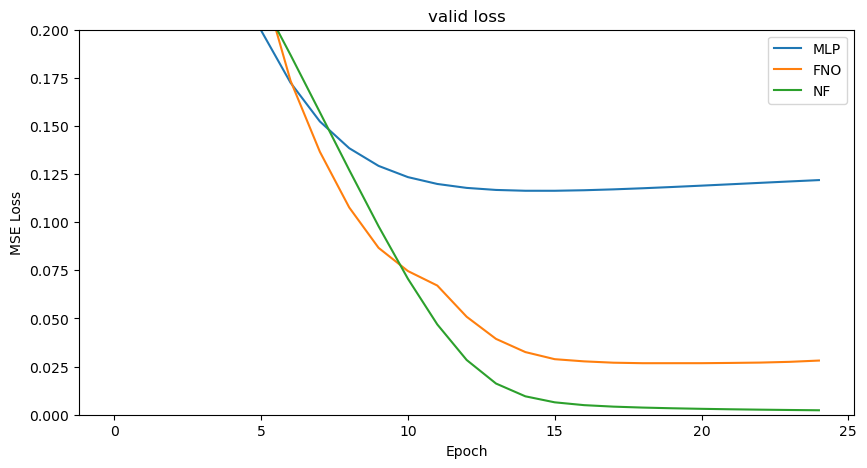

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(MLP_val_losses, label="MLP")
plt.plot(FNO_val_losses, label="FNO")
plt.plot(NF_val_losses, label="NF")
plt.title(f"valid loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.ylim(0, 0.2)

print("MLP valid loss: ", min(MLP_val_losses))
print("FNO valid loss: ", min(FNO_val_losses))
print("NF valid loss: ", min(NF_val_losses))

In [9]:
def get_derivatives(model, p_valid, x, mode="linear"):
    all_derivatives = []
    all_dF_du = []
    all_losses = []

    for i in range(len(p_valid)):
        u_input = get_u(p_valid[i], x).to(device)
        u_input.requires_grad = True
        u_input = u_input.unsqueeze(0).unsqueeze(-1) # b nx 1
        pred = model(u_input, x.unsqueeze(0).unsqueeze(-1)) # get F_theta[u(x)], shape b 1

        if hasattr(model, "get_derivative"):
            dF_du = model.get_derivative(pred, u_input, x.unsqueeze(0).unsqueeze(-1))
        else:
            dF_du = torch.autograd.grad(pred, u_input, torch.ones_like(pred), create_graph=True)[0] / dx

        if mode == "linear":
            dF_du_true = x**2
        else:
            dF_du_true = 3*u_input.squeeze()**2
            
        loss = F.mse_loss(dF_du.squeeze(), dF_du_true)
        
        all_losses.append(loss.item())
        all_derivatives.append(dF_du.detach().cpu())
        all_dF_du.append(dF_du_true.detach().cpu())
    return all_losses, all_derivatives, all_dF_du

MLP loss:  tensor(1.9960)
FNO loss:  tensor(2.0030)
NF loss:  tensor(0.0898)


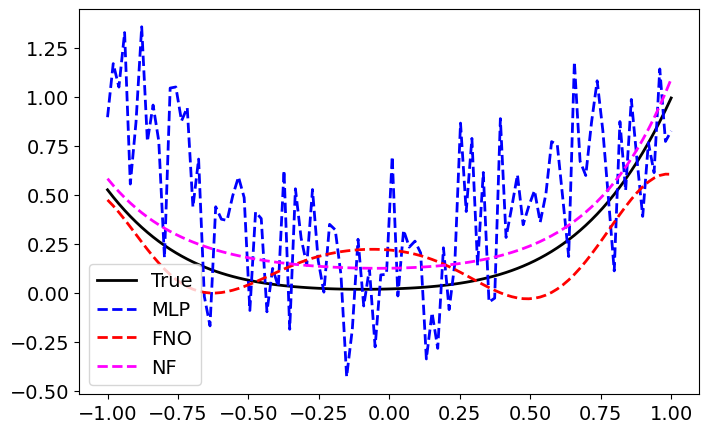

In [10]:
x = torch.linspace(-L, L, nx)
x = x.to(device)

#losses_MLP, dF_du_MLP, dF_du_true = get_derivatives(MLP_model, p_valid, x)
#losses_FNO, dF_du_FNO, _ = get_derivatives(FNO_model, p_valid, x)
#losses_NF, dF_du_NF, _ = get_derivatives(NF_model, p_valid, x)

losses_MLP, dF_du_MLP, dF_du_true = get_derivatives(MLP_model, p_valid, x, mode="nonlinear")
losses_FNO, dF_du_FNO, _ = get_derivatives(FNO_model, p_valid, x, mode="nonlinear")
losses_NF, dF_du_NF, _ = get_derivatives(NF_model, p_valid, x, mode="nonlinear")

print("MLP loss: ", torch.mean(torch.tensor(losses_MLP)))
print("FNO loss: ", torch.mean(torch.tensor(losses_FNO)))
print("NF loss: ", torch.mean(torch.tensor(losses_NF)))

i=6
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 14})
plt.plot(x.cpu(), dF_du_true[i].cpu().detach().squeeze(), label="True", linestyle="-", color="black", linewidth=2)
plt.plot(x.cpu(), dF_du_MLP[i].cpu().detach().squeeze(), label=f"MLP", linestyle="--", color="blue", linewidth=2)
plt.plot(x.cpu(), dF_du_FNO[i].cpu().detach().squeeze(), label=f"FNO", linestyle="--", color="red", linewidth=2)
plt.plot(x.cpu(), dF_du_NF[i].cpu().detach().squeeze(), label=f"NF", linestyle="--", color="magenta", linewidth=2)
#plt.title("Linear Functional Derivative: dF/du = x^2", fontsize=16)
#plt.title("Nonlinear Functional Derivative: dF/du = 3u^2", fontsize=16)
plt.legend(fontsize=14, loc="lower left")

In [11]:
import pickle 

out_dict = {"coord": x.cpu(),
            "p_valid": p_valid.cpu(),
            "dF_du_true": dF_du_true,
            "dF_du_MLP": dF_du_MLP,
            "dF_du_FNO": dF_du_FNO,
            "dF_du_NF": dF_du_NF,
            "MLP_losses": MLP_losses,
            "MLP_val_losses": MLP_val_losses,
            "FNO_losses": FNO_losses,
            "FNO_val_losses": FNO_val_losses,
            "NF_losses": NF_losses,
            "NF_val_losses": NF_val_losses,
            }

with open("logs/nonlinear_results.pkl", "wb") as f:
    pickle.dump(out_dict, f)

## Discretization invariance

In [12]:
x = torch.linspace(-L, L, nx) * 2 # x in domain [-2, 2] to test discretization invariance
dx = x[1] - x[0]
x = x.to(device)

def val(model, 
        func, 
        p_valid,
        x):
    
    losses_val = []
    n_valid = len(p_valid)
    avg_loss_val = 0

    with torch.no_grad():   
        for p_sample in p_valid:
            u_input = get_u(p_sample, x) # get u(x), shape (nx)
            u_input = u_input.unsqueeze(0).unsqueeze(-1) # b nx 1
            
            label = func(p_sample, x).to(device).unsqueeze(0)  # get F[u(x)], shape b 1
            pred = model(u_input, x.unsqueeze(0).unsqueeze(-1)) # get F_theta[u(x)], shape b 1

            loss = F.mse_loss(pred, label) 
            avg_loss_val += loss.item()
    
    losses_val.append(avg_loss_val / n_valid)

    return losses_val

In [13]:
#MLP_val_losses = val(MLP_model, F_l, p_valid, x)
#FNO_val_losses = val(FNO_model, F_l, p_valid, x)
#NF_val_losses = val(NF_model, F_l, p_valid, x)

MLP_val_losses = val(MLP_model, F_nl, p_valid, x)
FNO_val_losses = val(FNO_model, F_nl, p_valid, x)
NF_val_losses = val(NF_model, F_nl, p_valid, x)

print("MLP valid loss: ", min(MLP_val_losses))
print("FNO valid loss: ", min(FNO_val_losses))
print("NF valid loss: ", min(NF_val_losses))

MLP valid loss:  315.92989233732226
FNO valid loss:  282.2134242832661
NF valid loss:  62.259314889833334


MLP loss:  tensor(74.6944)
FNO loss:  tensor(70.2759)
NF loss:  tensor(29.5055)


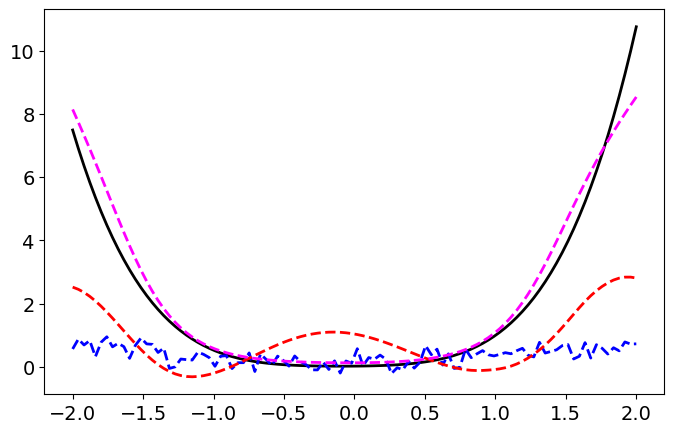

In [14]:
#losses_MLP, dF_du_MLP, dF_du_true = get_derivatives(MLP_model, p_valid, x)
#losses_FNO, dF_du_FNO, _ = get_derivatives(FNO_model, p_valid, x)
#losses_NF, dF_du_NF, _ = get_derivatives(NF_model, p_valid, x)

losses_MLP, dF_du_MLP, dF_du_true = get_derivatives(MLP_model, p_valid, x, mode="nonlinear")
losses_FNO, dF_du_FNO, _ = get_derivatives(FNO_model, p_valid, x, mode="nonlinear")
losses_NF, dF_du_NF, _ = get_derivatives(NF_model, p_valid, x, mode="nonlinear")

print("MLP loss: ", torch.mean(torch.tensor(losses_MLP)))
print("FNO loss: ", torch.mean(torch.tensor(losses_FNO)))
print("NF loss: ", torch.mean(torch.tensor(losses_NF)))

i=6
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 14})
plt.plot(x.cpu(), dF_du_true[i].cpu().detach().squeeze(), label="True", linestyle="-", color="black", linewidth=2)
plt.plot(x.cpu(), dF_du_MLP[i].cpu().detach().squeeze(), label=f"MLP", linestyle="--", color="blue", linewidth=2)
plt.plot(x.cpu(), dF_du_FNO[i].cpu().detach().squeeze(), label=f"FNO", linestyle="--", color="red", linewidth=2)
plt.plot(x.cpu(), dF_du_NF[i].cpu().detach().squeeze(), label=f"NF", linestyle="--", color="magenta", linewidth=2)
#plt.title("Linear Functional Derivative: dF/du = x^2", fontsize=16)
#plt.title("Nonlinear Functional Derivative: dF/du = 3u^2", fontsize=16)
#plt.legend(fontsize=14)
#plt.legend(fontsize=14, loc="upper left")